In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import pylab as pl #繪圖
import torch.nn.init as init

接下來，我們將設置模型超參數，輸入層的大小設置為7，這意味著我們將有6個上下文神經元和1個輸入神經元，seq_length定義我們的輸入和目標序列的長度。

In [2]:
dtype = torch.FloatTensor
input_size = 7
hidden_size = 6
output_size = 1
epochs = 300
seq_length = 20 #輸入長度，RNN的序列，這數字來自於data要放入的長度
lr = 0.1 #學習率

In [3]:
data_time_steps = np.linspace(2, 10, seq_length + 1) #指定區間產生平均的數值，產生2~10共21個，畫圖區間使用

In [4]:
data_time_steps

array([ 2. ,  2.4,  2.8,  3.2,  3.6,  4. ,  4.4,  4.8,  5.2,  5.6,  6. ,
        6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,  9.2,  9.6, 10. ])

In [5]:
data = np.sin(data_time_steps) #轉sin

In [6]:
data

array([ 0.90929743,  0.67546318,  0.33498815, -0.05837414, -0.44252044,
       -0.7568025 , -0.95160207, -0.99616461, -0.88345466, -0.63126664,
       -0.2794155 ,  0.1165492 ,  0.49411335,  0.79366786,  0.96791967,
        0.98935825,  0.85459891,  0.58491719,  0.22288991, -0.17432678,
       -0.54402111])

In [7]:
data.resize((seq_length + 1, 1))#調整成1行,21

In [8]:
data

array([[ 0.90929743],
       [ 0.67546318],
       [ 0.33498815],
       [-0.05837414],
       [-0.44252044],
       [-0.7568025 ],
       [-0.95160207],
       [-0.99616461],
       [-0.88345466],
       [-0.63126664],
       [-0.2794155 ],
       [ 0.1165492 ],
       [ 0.49411335],
       [ 0.79366786],
       [ 0.96791967],
       [ 0.98935825],
       [ 0.85459891],
       [ 0.58491719],
       [ 0.22288991],
       [-0.17432678],
       [-0.54402111]])

現在我們將建立訓練數據，其中x是輸入序列，y是目標序列。

In [9]:
x = Variable(torch.Tensor(data[:-1]).type(dtype), requires_grad=False)
y = Variable(torch.Tensor(data[1:]).type(dtype), requires_grad=False)

# 說明Variable強大功能

In [10]:
import torch
from torch.autograd import Variable # torch 中 Variable 模块

# 先生鸡蛋
tensor = torch.FloatTensor([[1,2],[3,4]])
# 把鸡蛋放到篮子里, requires_grad是参不参与误差反向传播, 要不要计算梯度
variable = Variable(tensor, requires_grad=True)

print(tensor)

tensor([[1., 2.],
        [3., 4.]])


In [11]:
print(variable)

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


In [12]:
t_out = torch.mean(tensor*tensor)       # x^2
v_out = torch.mean(variable*variable)   # x^2
print(t_out)
print(v_out)    # 7.5


tensor(7.5000)
tensor(7.5000, grad_fn=<MeanBackward1>)


Variable計算時搭配computational graph，將所有反向傳播的結點連接起來，方便一次把梯度都計算出來

In [13]:
v_out.backward() 
#d(v_out)/d(variable) = 1/4*2*variable = variable/2
#Tensor也可以計算，但是無法作backward

In [14]:
print(variable.grad)

tensor([[0.5000, 1.0000],
        [1.5000, 2.0000]])


In [15]:
#各種variable形式
print(variable)  # Variable 形式
print(variable.data)  # data 形式
print(variable.data.numpy()) # numpy 形式

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
tensor([[1., 2.],
        [3., 4.]])
[[1. 2.]
 [3. 4.]]


# 說明Variable強大功能(結束)

In [16]:
data

array([[ 0.90929743],
       [ 0.67546318],
       [ 0.33498815],
       [-0.05837414],
       [-0.44252044],
       [-0.7568025 ],
       [-0.95160207],
       [-0.99616461],
       [-0.88345466],
       [-0.63126664],
       [-0.2794155 ],
       [ 0.1165492 ],
       [ 0.49411335],
       [ 0.79366786],
       [ 0.96791967],
       [ 0.98935825],
       [ 0.85459891],
       [ 0.58491719],
       [ 0.22288991],
       [-0.17432678],
       [-0.54402111]])


我們需要創建兩個權重矩陣，w1的大小（input_size，hidden_​​size）用於輸入到隱藏連接，而w2矩陣的大小（hidden_​​size，output_size）用於隱藏到輸出連接。使用具有零均值的正態分佈初始化權重。

In [17]:
#初始化
w1 = torch.FloatTensor(input_size, hidden_size).type(dtype)
init.normal_(w1, 0.0, 0.4) # init.normal 舊版  mean=0.0, std=0.4 (低離散程度)
w1 =  Variable(w1, requires_grad=True) #requires_grad=True 需要反向傳播
w2 = torch.FloatTensor(hidden_size, output_size).type(dtype)
init.normal_(w2, 0.0, 0.4) # init.normal 舊版 mean=0.0, std=0.3 (低離散程度)
w2 = Variable(w2, requires_grad=True) #requires_grad=True 需要反向傳播
# w1作為輸入，w2最為輸出

In [18]:
w2

tensor([[-0.5965],
        [-0.2055],
        [-0.2924],
        [-0.1614],
        [-0.0427],
        [ 0.0236]], requires_grad=True)

我們現在可以定義forward方法，它將輸入向量，context_state為Autograd的結果，整合兩個權重矩陣作為參數。我們將通過將輸入向量與context_state向量連接來創建向量xh。我們在xh向量和權重矩陣w1之間執行點積，然後將tanh函數應用為非線性，這對於RNN而言比sigmoid更好。然後我們在新的context_state和權重矩陣w2之間執行另一個點積。我們想要預測連續值，所以我們在這個階段不應用任何非線性。

請注意，context_state將用於在下一個時間步驟填充上下文神經元。這就是我們返回context_state向量以及網絡輸出的原因。


In [19]:
#context_state
#Variable(torch.zeros((1, hidden_size)).type(dtype), requires_grad=True)

In [20]:
def forward(input, context_state, w1, w2):
  xh = torch.cat((input, context_state), 1) #將input與context_state做連接，並成為列(Row)呈現
  context_state = torch.tanh(xh.mm(w1)) #先對w1作內積，相近的數值就接近，再轉換tanh收斂到-1~1
  out = context_state.mm(w2) #再對w2做內積作為輸出
  return  (out, context_state) #回傳context_state與out

# torch.cat 快速說明

In [21]:
x_t = torch.randn(4, 6)
x_t

tensor([[-0.6497,  0.2220, -0.1584,  0.0877,  0.1764, -1.7362],
        [-0.1475,  2.0566, -0.1578,  0.6652,  0.3990,  1.2273],
        [-1.4531,  1.5406,  0.2388,  1.0145,  1.7663, -0.5078],
        [-0.9400, -0.7034,  0.1799, -1.6558,  1.1217, -1.5902]])

In [22]:
torch.cat((x_t, x_t, x_t), 0)

tensor([[-0.6497,  0.2220, -0.1584,  0.0877,  0.1764, -1.7362],
        [-0.1475,  2.0566, -0.1578,  0.6652,  0.3990,  1.2273],
        [-1.4531,  1.5406,  0.2388,  1.0145,  1.7663, -0.5078],
        [-0.9400, -0.7034,  0.1799, -1.6558,  1.1217, -1.5902],
        [-0.6497,  0.2220, -0.1584,  0.0877,  0.1764, -1.7362],
        [-0.1475,  2.0566, -0.1578,  0.6652,  0.3990,  1.2273],
        [-1.4531,  1.5406,  0.2388,  1.0145,  1.7663, -0.5078],
        [-0.9400, -0.7034,  0.1799, -1.6558,  1.1217, -1.5902],
        [-0.6497,  0.2220, -0.1584,  0.0877,  0.1764, -1.7362],
        [-0.1475,  2.0566, -0.1578,  0.6652,  0.3990,  1.2273],
        [-1.4531,  1.5406,  0.2388,  1.0145,  1.7663, -0.5078],
        [-0.9400, -0.7034,  0.1799, -1.6558,  1.1217, -1.5902]])

In [23]:
torch.cat((x_t, x_t, x_t), 1)

tensor([[-0.6497,  0.2220, -0.1584,  0.0877,  0.1764, -1.7362, -0.6497,  0.2220,
         -0.1584,  0.0877,  0.1764, -1.7362, -0.6497,  0.2220, -0.1584,  0.0877,
          0.1764, -1.7362],
        [-0.1475,  2.0566, -0.1578,  0.6652,  0.3990,  1.2273, -0.1475,  2.0566,
         -0.1578,  0.6652,  0.3990,  1.2273, -0.1475,  2.0566, -0.1578,  0.6652,
          0.3990,  1.2273],
        [-1.4531,  1.5406,  0.2388,  1.0145,  1.7663, -0.5078, -1.4531,  1.5406,
          0.2388,  1.0145,  1.7663, -0.5078, -1.4531,  1.5406,  0.2388,  1.0145,
          1.7663, -0.5078],
        [-0.9400, -0.7034,  0.1799, -1.6558,  1.1217, -1.5902, -0.9400, -0.7034,
          0.1799, -1.6558,  1.1217, -1.5902, -0.9400, -0.7034,  0.1799, -1.6558,
          1.1217, -1.5902]])

# torch.cat 快速說明結束

我們的建立循環結構如下。

在每個迭代的開始，為了確保context_state是乾淨的，我們需要用初始化我們的context_state向量。

環遍歷序列的每個元素。我們前進的方法執行返回將用於下一個步驟的預測和context_state的前向傳遞。然後我們計算均方誤差（MSE），當我們想要預測連續值時，這是一個自然的選擇。通過在損失上運行backward（）方法我們計算梯度，然後我們更新權重。我們應該通過調用zero_（）方法清除每次迭代的漸變，否則將累積漸變。我們做的最後一件事是將context_state向量包裝在新的Variable中，以將其從歷史記錄中分離出來。

In [24]:
for i in range(epochs):
  total_loss = 0
  #裝RNN的資料context_state
  context_state = Variable(torch.zeros((1, hidden_size)).type(dtype), requires_grad=True)
    #起始為0  0  0  0  0  0 因為hidden_size設定為6
  for j in range(x.size(0)): #x.size(0)確保是正確數字
    input = x[j:(j+1)] #依序將0.9093、0.6755取出
    target = y[j:(j+1)] #依序將0.6755、0.3350、-0.0584、-0.4425取出
    (pred, context_state) = forward(input, context_state, w1, w2)
    #實際-預測 計算Loss MSE
    loss = (pred - target).pow(2).sum()/2
    total_loss += loss
    loss.backward()
    #加上學習速率，加得越大數值跳越快，權重重新產生
    w1.data -= lr * w1.grad.data 
    w2.data -= lr * w2.grad.data
    w1.grad.data.zero_()
    w2.grad.data.zero_()
    context_state = Variable(context_state.data)
  if i % 100 == 0: #取餘數，讓他變成10次顯示一次
     print("Epoch: {} loss {}".format(i, total_loss.data[0]))
     print(w2)

Epoch: 0 loss 1.2071304321289062
tensor([[-0.6312],
        [-0.3480],
        [-0.2185],
        [-0.1919],
        [-0.1722],
        [ 0.1395]], requires_grad=True)


/Users/jerrywu2018/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 100 loss 0.015333490446209908
tensor([[-0.5041],
        [-0.4300],
        [ 0.1002],
        [-0.1007],
        [-0.5802],
        [ 0.0794]], requires_grad=True)
Epoch: 200 loss 0.0076925186440348625
tensor([[-0.4728],
        [-0.4341],
        [ 0.1168],
        [-0.0699],
        [-0.6546],
        [ 0.1180]], requires_grad=True)


In [ ]:
for i in range(epochs):
  total_loss = 0
  context_state = Variable(torch.zeros((1, hidden_size)).type(dtype), requires_grad=True)
  for j in range(x.size(0)): 
    input = x[j:(j+1)] 
    target = y[j:(j+1)] 
    (pred, context_state) = forward(input, context_state, w1, w2)
    loss = (pred - target).pow(2).sum()/2
    total_loss += loss
    loss.backward()
    w1.data -= lr * w1.grad.data 
    w2.data -= lr * w2.grad.data
    w1.grad.data.zero_()
    w2.grad.data.zero_()
    context_state = Variable(context_state.data)
  if i % 100 == 0:
     print("Epoch: {} loss {}".format(i, total_loss.data[0]))

訓練期間產生的輸出顯示每個時期的損失如何減少，這是一個好兆頭。衰退損失意味著我們的模型正在學習。

一旦我們的模型被訓練，我們就可以進行預測，在序列的每個步驟中，我們將使用單個數據點為模型提供信息，並要求模型在下一個時間步驟預測一個值。

In [27]:
context_state = Variable(torch.zeros((1, hidden_size)).type(dtype), requires_grad=False)
predictions = []

for i in range(x.size(0)):
  input = x[i:i+1]
  (pred, context_state) = forward(input, context_state, w1, w2) #w1,w2是由上面帶下來的數值
  context_state = context_state
  predictions.append(pred.data.numpy().ravel()) #透過data.numpy將pred轉numpy,透過數據ravel整理一下
  #print("predictions==========", predictions)

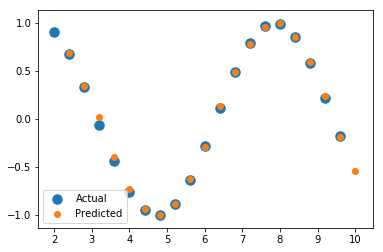

In [28]:
#data_time_steps為x軸,x.data.numpy為Y軸
pl.scatter(data_time_steps[:-1], x.data.numpy(), s=90, label="Actual") # s= 圈圈大小
pl.scatter(data_time_steps[1:], predictions, label="Predicted")
pl.legend()
pl.show()